# Installation
The purpose of this notebook is to give a working example of the library and how to use it. First, we begin by installing the library. Note that it takes some time to install the library because of the dependencies, be patient!

In [1]:
%pip install git+https://github.com/JadM133/RRAEs.git@VAE_fix_CNN

  Cloning https://github.com/JadM133/RRAEs.git (to revision VAE_fix_CNN) to c:\users\jadmo\appdata\local\temp\pip-req-build-o6yfrq7b
  Resolved https://github.com/JadM133/RRAEs.git to commit a0f21f0392ba6c5cf046112daaf0c2e499b79e2d
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/JadM133/RRAEs.git 'C:\Users\jadmo\AppData\Local\Temp\pip-req-build-o6yfrq7b'
  Running command git checkout -b VAE_fix_CNN --track origin/VAE_fix_CNN
  branch 'VAE_fix_CNN' set up to track 'origin/VAE_fix_CNN'.
  Switched to a new branch 'VAE_fix_CNN'


Now that the library is installed, you can acces the library with the name ``RRAEs``. We begin by creating a simple training data, the library presents a function within ``utilities`` named ``get_data`` that generates the data used in the paper and many more. In this case, we will use the shifted sine functions as a simple example.

Train shape: (200, 17), or (200, 17)
Test shape: (200, 80), or (200, 80)
Train parameters shape: (17, 1)
Test parameters shape: (80, 1)


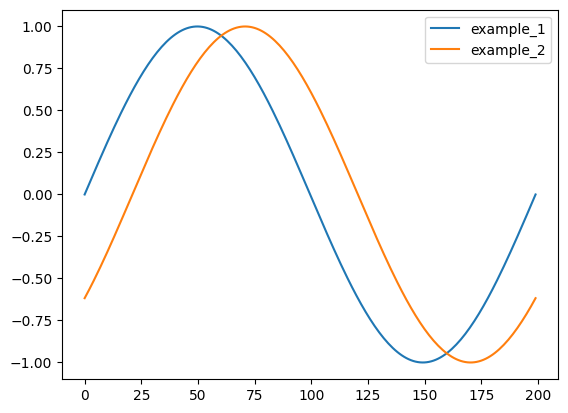

In [2]:
from RRAEs.utilities import get_data
import matplotlib.pyplot as plt
import jax.numpy as jnp
x_train, x_test, p_train, p_test, y_train, y_test, _ = get_data("shift")
# In general, you won't use get_data, you will have your own data with the same shapes.
print(f"Train shape: {x_train.shape}, or {y_train.shape}")
print(f"Test shape: {x_test.shape}, or {y_test.shape}")
print(f"Train parameters shape: {p_train.shape}")
print(f"Test parameters shape: {p_test.shape}")
plt.plot(x_train[:, 0], label="example_1")
plt.plot(x_train[:, 2], label="example_2")
plt.legend()

In this case, ``x_train`` and ``y_train`` are the same matrices, since we want the autoencoder to have as an output the same thing as the input. Similarly, ``x_test`` and ``y_test`` are the same. We can also see that we only have one parameter (the last dimension of ``p_train`` and ``p_test``), which is expected for the problem of the shifted sines (shifted by one parameter). In general, when generating your own data, x and y should have the shape (T x N) and the parameters should have a shape of (N x P), N being the number of samples (wether for train or test), T being the time discretisation dimension, and P being the dimension of the parametric space.

Next, we creat the model,

In [3]:
from RRAEs import Strong_RRAE_MLP, Weak_RRAE_MLP
import jax.random as jrandom
latent_size = 520
k_max = 1
kwargs_enc={"width_size":64, "depth":1}
kwargs_dec={"width_size":64, "depth":5}
model_key = jrandom.PRNGKey(0) # JAX needs key for generating random values, this is a necessary keword argument in the classes.

model_Strong = Strong_RRAE_MLP(x_train.shape[0], latent_size, k_max, key=model_key, kwargs_enc=kwargs_enc, kwargs_dec=kwargs_dec)
model_Weak = Weak_RRAE_MLP(x_train.shape[0], latent_size, k_max, x_train.shape[-1], key=model_key, kwargs_enc=kwargs_enc, kwargs_dec=kwargs_dec)

# You can give any kwargs needed for the encoder in kwargs_enc, and for the decoder in kwargs_dec. If nothing is given,
# the encoder will have a depth of 1 and a width of 64, and the decoder will have a depth of 6 and a width of 64.

Let's test the models now by aplying them to our training data.

In [4]:
print(f"x_train shape before: {x_train.shape}")
print(f" Shape after Strong: {model_Strong(x_train).shape}")
print(f" Shape after Weak: {model_Weak(x_train).shape}")

x_train shape before: (200, 17)
 Shape after Strong: (200, 17)
 Shape after Weak: (200, 17)


We expect all shapes to be the same since we want to predict the original values as output, great!

The Strong formulation performs a truncates SVD after the latent space, while the weak one for now is just a Vanilla Autoencoder, the difference will come in the loss later on.

Now, let's train the model on our data. The library provides a trainor class that does the training for you, if you know how to use it :) 

We define the trainor class for each of the Weak/Strong formulation as follows (In practice, you only need one of these).

In [5]:
from RRAEs import AE_Trainor_class 
# You can use Trainor_class instead for any other equinox model, 
# AE_trainor_class only has some extra post_processing features
# for Autoencoders.

model_cls = Strong_RRAE_MLP # Without parenthesis! Only the class

trainor_Strong = AE_Trainor_class(
            x_train,
            model_cls,
            in_size=x_train.shape[0],
            latent_size=latent_size,  # 4600
            k_max=k_max,
            norm_in="minmax", # could choose "meanstd", or "None"
            norm_out="minmax", # could choose "meanstd", or "None"
            out_train=x_train,
            folder=f"test/", # folder to save later
            file=f"testing_strong", # file in folder to save later
            key=jrandom.PRNGKey(0),
        )

model_cls = Weak_RRAE_MLP # Without parenthesis! Only the class
trainor_Weak = AE_Trainor_class(
            x_train,
            model_cls,
            latent_size=latent_size,  # 4600
            in_size=x_train.shape[0],
            data_size=x_train.shape[-1], # Only needed for Weak_RRAE_MLP
            k_max=k_max,
            folder=f"test/",
            file=f"testing_Weak",
            norm_in="minmax", # could choose "meanstd", or "None"
            norm_out="minmax", # could choose "meanstd", or "None"
            out_train=x_train,
            key=jrandom.PRNGKey(100),
        )

Now, we can use the ``fit`` method of the trainor class, and give it any training arguments as follows,

In [6]:
training_kwargs = {
            "step_st": [1500], # number of batches strategy
            "batch_size_st": [20, 20, 20], # batch size strategy
            "lr_st": [1e-3, 1e-4], # learning rate strategy
            "print_every": 100,
        }

_ = trainor_Strong.fit(
    x_train,
    y_train,
    loss_func="Strong",
    training_key=jrandom.PRNGKey(50),
    **training_kwargs,
)

Training the RRAE...
Step: 0, Loss: 99.69287872314453, Computation time: 0.8264507001731545
Step: 100, Loss: 57.13981246948242, Computation time: 0.5860617004800588
Step: 200, Loss: 41.78825378417969, Computation time: 0.5455931988544762
Step: 300, Loss: 40.3974723815918, Computation time: 0.5116010999772698
Step: 400, Loss: 11.209572792053223, Computation time: 0.5238518004771322
Step: 500, Loss: 6.429886817932129, Computation time: 0.5357806000392884
Step: 600, Loss: 4.363488674163818, Computation time: 0.5294691999442875
Step: 700, Loss: 3.8151535987854004, Computation time: 0.503251699032262
Step: 800, Loss: 3.461122989654541, Computation time: 0.5059288006741554
Step: 900, Loss: 3.3449344635009766, Computation time: 0.5319969004485756
Step: 1000, Loss: 5.9743428230285645, Computation time: 0.4761227995622903
Step: 1100, Loss: 4.691559314727783, Computation time: 0.5452273988630623
Step: 1200, Loss: 3.647223472595215, Computation time: 0.5812852000817657
Step: 1300, Loss: 1.7814131

We trained RRAEs with the Strong formulation!!! Training using the Weak formulation is Similar, by replacing ``loss_func`` by ``Weak`` the loss automatically includes matrices ``U`` and ``A`` in the loss (check the paper for more details). The only difference is that we might multiply the learning rate before modifying the gradient of ``A`` (check Appendix B in the paper for why and how this helps, instead of modifying the loss constants). This is done as follows,

In [7]:
# training_kwargs = {
#             "step_st": [1500, 1500], # number of batches strategy
#             "batch_size_st": [20, 20, 20], # batch size strategy
#             "lr_st": [1e-3, 1e-4], # learning rate strategy
#             "print_every": 100,
#             # For now, the next two lines have some unfixed bugs...
#             # "mul_lr":[0.05, 0.05, 0.05], # The values of kappa (to multiply lr for A)
#             # "mul_lr_func": lambda tree: (tree.v_vt.vt,), # Who will be affected by kappa, this means A
#         }
# _ = trainor_Weak.fit(
#     x_train,
#     y_train,
#     loss_func="Weak",
#     training_key=jrandom.PRNGKey(50),
#     **training_kwargs,
# )

As you can see, choosing the Weak option for the loss function will automatically print loss1 and loss2, the first being how far our prediction of the input is, and loss2 give us an idea of how low the rank is. If loss2 is decreasing too fast, you should decrease the value of kappa (i.e. mul_lr), otherwise, you must increase it.

Next, we show how to post process the results. The trainor class offer a method that allow post processing. This method takes the training data, the test data (optional), and corresponding parameters (optional). If the test data is give, it will be passed into the trained autoencoder and projected onto the basis found in training. If the parameters are given (i.e. p_train and p_test), the latent space of the test set is found using linear interpolation in the latent space and then decoded to find the predictions. All the results are sotred as attributes in the trainor class.

In [8]:
trainor_Strong.post_process(x_train, y_train, x_test, y_test, p_train, p_test)
# error_train_we, error_test_we, _, _ = trainor_Weak.post_process(x_train, y_train)

Train error on original output:  2.7429767
Train error on normalized output:  1.5840865
Total training time:  8.789686998119578
Test error on original output:  6.0148683
Test error on normalized output:  3.472827
Test (interpolation) error over original output:  3.5623019
Test (interpolation) error over normalized output:  2.0567794


Just an idea about the attributes stored after post processing:

In [15]:
trainor_Strong.__dict__.keys()
# Predictions over the train dataset
trainor_Strong.y_pred_train_o # _o is for original (i.e. after inversing output normalization)
trainor_Strong.y_train_o # the original target
trainor_Strong.y_pred_train # the normalized prediction
trainor_Strong.y_train # the normalized target
trainor_Strong.error_train_o # the error in the original space
trainor_Strong.error_train # the error in the normalized space

# Predictions over the test dataset, note that these are the results of passing x_test provided
# above into the autoencoder, and projecting it into the same basis as the train set in the 
# latent space.
trainor_Strong.y_pred_test_o # _o is for original (i.e. after inversing output normalization)
trainor_Strong.y_test_o # the original target
trainor_Strong.y_pred_test # the normalized prediction
trainor_Strong.y_test # the normalized target
trainor_Strong.error_test_o # the error in the original space
trainor_Strong.error_test # the error in the normalized space

# Prediction over test dataset, but interpolated using p_test within p_train. In this case we find
# the closest values of p_train, and interpolate linear their corresponding latent spaces before
# decoding the result. This is how, for a specified parameter value p_test, we can find the
# corresponding curve.
trainor_Strong.y_pred_interp_test_o # _o is for original (i.e. after inversing output normalization)
trainor_Strong.y_test_o # the original target
trainor_Strong.y_pred_interp_test # the normalized prediction
trainor_Strong.y_test # the normalized target
trainor_Strong.error_interp_test_o # the error in the original space
trainor_Strong.error_interp_test # the error in the normalized space

Array(2.0567794, dtype=float32)

The autoencoder model also allows you to perform seperate operations (e.g. encoe and decode), normalization is done automatically.

In [11]:
encoded = trainor_Strong.model.encode(x_train) # data is normalized before encode

# The function above only encodes, but RRAEs have a function in the latent space
# (i.e. the SVD), so we can also find the latent space by doing the following:
latent = trainor_Strong.model.latent(x_train) # data is normalized before latent

# Then we can decode the results to find the prediction
decoded = trainor_Strong.model.decode(latent) # data is inv normalized after decode
print(jnp.linalg.norm(x_train - decoded)/jnp.linalg.norm(x_train)*100)

2.743033


Note that the function "latent", has some useful arguments as well:

In [16]:
# ret=True returns the basis, coefficients and singular values of the
# truncated SVD in the latent space (Note: if the svd is USV^T, then
# the basis is U, the coefficients are SV^T). S is returned as the final
# output in case it is needed.
basis, coeffs, sigs = trainor_Strong.model.latent(x_train, ret=True)

# By default, the latent space performs the truncated SVD by the value of
# k_max specified above. If basis is given as an argument, the autoencoder
# passes the data into the encoder, and the projects the data on the known
# basis. This is usually done for the test data, since we do not perform
# the SVD on the test set, we simply project them on the previosuly found
# basis of the train set.
latent_space = trainor_Strong.model.latent(x_train, basis=basis)

Finally, if your dataset is too large and need to batch the data for a certain function, trainor class allows you to do so as follows:

In [20]:
# The function you want to call on the batched input has to take only as input
# x (one argument) and can output anything (refer next to managing output form).
call_func = lambda x: trainor_Strong.model.latent(x, ret=True)[0]

latent_space_mean = trainor_Strong.model.eval_with_batches(x_train, batch_size=32, call_func=call_func, end_type="mean", key=jrandom.key(0))

print(f"Mean shape: {latent_space_mean.shape}")

latent_space_all = trainor_Strong.model.eval_with_batches(x_train, batch_size=32, call_func=call_func, key=jrandom.key(0))

print(f"All shape: {latent_space_all.shape}")

# NOTE: Depending on the output of your function, you might want to change the end_type.
# By default, the function assumes only ONE ARRAY as an output, so the results of each batch
# are appended in a list, and the concatenated along the last dimension. You could chose end_type
# to be "mean" where the function would return the mean of the list, "first" if you only want the result
# over the first batch, and None if you want the list of results. 

Mean shape: (520, 1)
All shape: (520, 17)


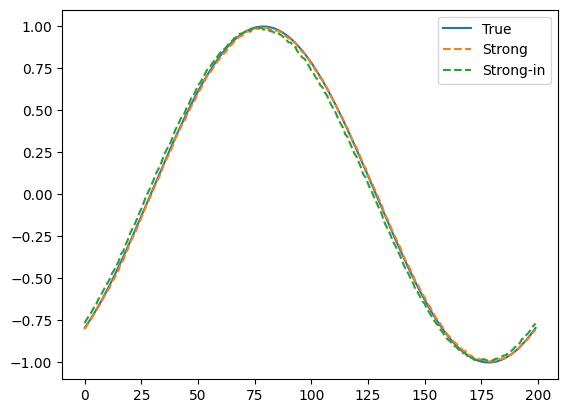

In [21]:
idx = 15
plt.plot(y_test[:, idx], label="True")
plt.plot(trainor_Strong.y_pred_interp_test_o[:, idx], label="Strong", linestyle="--")
plt.plot(trainor_Strong.y_pred_test_o[:, idx], label="Strong-in", linestyle="--")
# plt.plot(trainor_Weak.y_pred_test[:, 10], label="Weak", linestyle="--")
plt.legend()

Finally, you can save the model by using the built-in ``save`` function of the trainor class, it will save the model in the foler and file that you specified previously when defining the trainor class as follows.

In [13]:
trainor_Strong.save(coeffs=coeffs, basis=basis) # you could save any other parameter by passing it as a keyword argument
trainor_Weak.save(coeffs=coeffs, basis=basis)

Model saved in test/testing_strong.pkl
Model saved in test/testing_Weak.pkl


Later on, if you want to load the trainor again, you define a trainor class instance with no attributes and load the class as follows

In [22]:
import os
folder = f"test/"
file = f"testing_weak"
new_trainor = AE_Trainor_class()
new_trainor.load(os.path.join(folder, file))